In [1]:
import pandas as pd
import boto3
# import S3FS
import os.path
from pathlib import Path
from pyspark.sql import SparkSession
from boto3.session import Session
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from matplotlib.pyplot import figure
from helper_func import *
pd.set_option('display.max_rows', None)
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot


In [2]:
data = pd.read_csv("emscad_v1.csv")

In [3]:
data.columns


Index(['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'in_balanced_dataset'],
      dtype='object')

In [4]:
data.head()

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Marketing Intern,"US, NY, New York",Marketing,NaN,"<h3>We're Food52, and we've created a groundbr...","<p>Food52, a fast-growing, James Beard Award-w...",<ul>\r\n<li>Experience with content management...,NaN,f,t,f,Other,Internship,NaN,NaN,Marketing,f,f
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"<h3>90 Seconds, the worlds Cloud Video Product...",<p>Organised - Focused - Vibrant - Awesome!<br...,<p><b>What we expect from you:</b></p>\r\n<p>Y...,<h3><b>What you will get from us</b></h3>\r\n<...,f,t,f,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,f,f
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,<h3></h3>\r\n<p>Valor Services provides Workfo...,"<p>Our client, located in Houston, is actively...",<ul>\r\n<li>Implement pre-commissioning and co...,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,<p>Our passion for improving quality of life t...,<p><b>THE COMPANY: ESRI – Environmental System...,<ul>\r\n<li>\r\n<b>EDUCATION: </b>Bachelor’s o...,<p>Our culture is anything but corporate—we ha...,f,t,f,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,f,f
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,<p>SpotSource Solutions LLC is a Global Human ...,<p><b>JOB TITLE:</b> Itemization Review Manage...,<p><b>QUALIFICATIONS:</b></p>\r\n<ul>\r\n<li>R...,<p>Full Benefits Offered</p>,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,f,f


In [5]:
data.to_pickle("data.pkl")

In [6]:
data.drop("in_balanced_dataset", inplace = True, axis = 1)

In [7]:
data["fraudulent"] = data["fraudulent"].replace(["f" , "t"], ["Not Fraud", "Fraud"])

In [8]:
fraud_prop = data.groupby("fraudulent").size().reset_index(name = "counts")
x = np.array(fraud_prop.iloc[:,0])
y = np.array(fraud_prop.iloc[:,1])
total = y.sum()

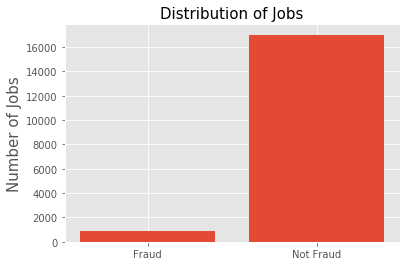

In [9]:
fig = plt.figure()
plt.bar(x, y) 
plt.ylabel("Number of Jobs", fontsize=15) 
plt.title("Distribution of Jobs", fontsize=15)
fig.savefig('images/fraud.png', bbox_inches='tight');

<Figure size 432x288 with 0 Axes>

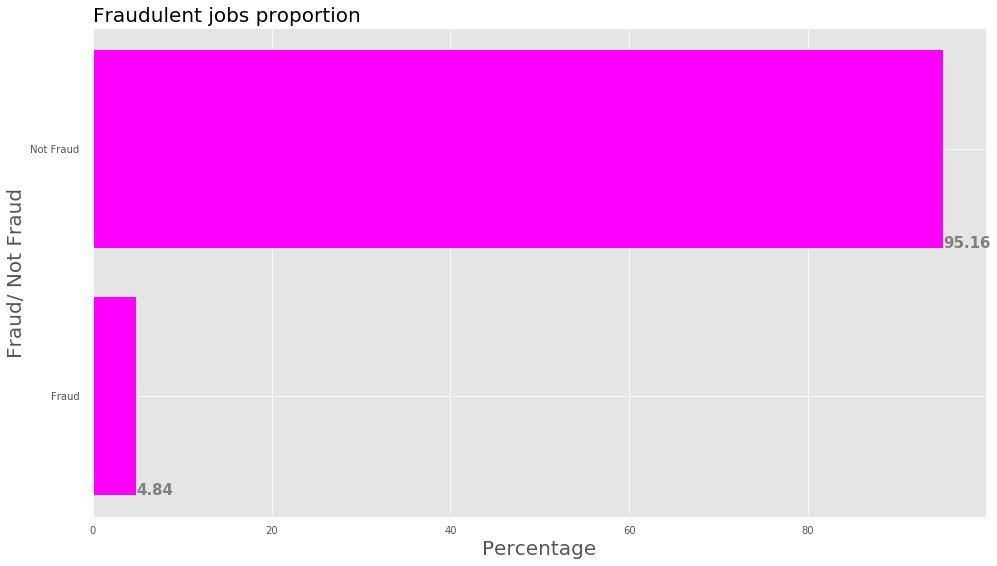

In [10]:
# fraud distribution percentages
fig = plt.figure()
fig, ax = plt.subplots(figsize =(16, 9))
ax.barh(x, y*100/total, color="magenta")
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_tick_params(pad = 5) 
ax.yaxis.set_tick_params(pad = 10)
for i in ax.patches: 
    plt.text(i.get_width(), i.get_y(),  
             str(round((i.get_width()), 2)), 
             fontsize = 15, fontweight ='bold', 
             color ='grey')
    
ax.set_title("Fraudulent jobs proportion", 
             loc ='left', fontsize =20) 
ax.set_ylabel("Fraud/ Not Fraud", fontsize =20)
ax.set_xlabel("Percentage", fontsize =20)
fig.savefig('images/fraud_perc.png', bbox_inches='tight')

In [11]:
data["fraudulent"] = data["fraudulent"].replace(["Not Fraud", "Fraud"], [0,1])

binary_cols = ["telecommuting", "has_company_logo","has_questions"]

for col in binary_cols:
    binarize(data,col)



In [12]:
fill_nulls(data)

<Figure size 432x288 with 0 Axes>

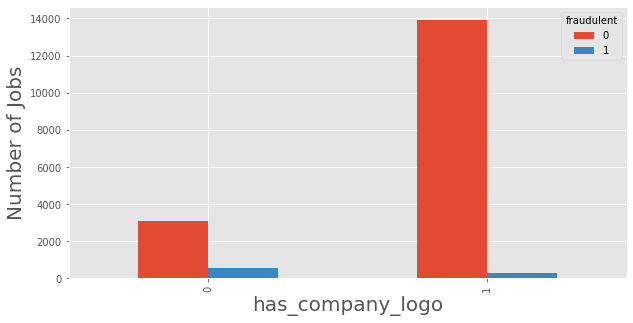

<Figure size 432x288 with 0 Axes>

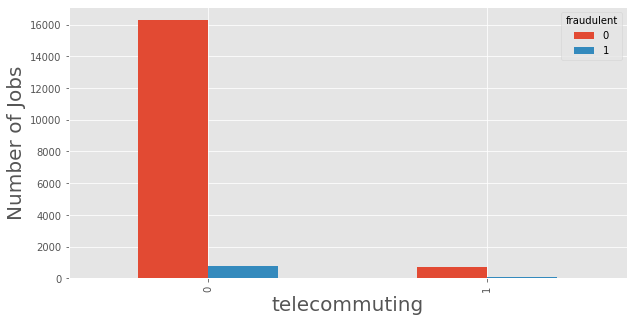

<Figure size 432x288 with 0 Axes>

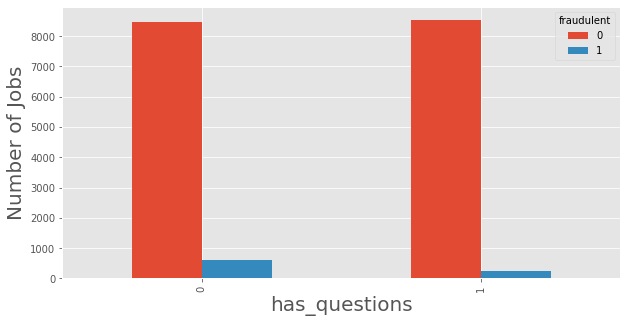

<Figure size 432x288 with 0 Axes>

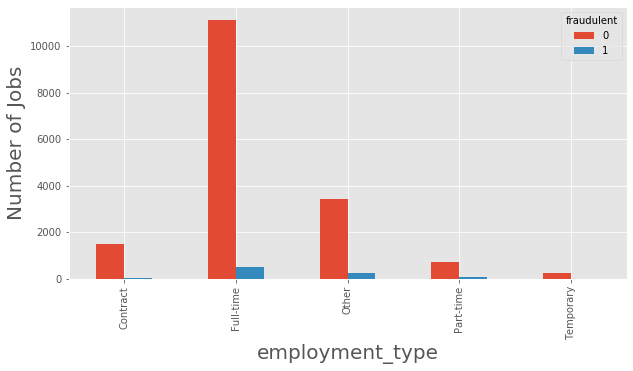

In [13]:
cols = ["has_company_logo","telecommuting", "has_questions", "employment_type" ]

for col in cols:
    plot_bar(data,col)

In [14]:
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]

for col in text_cols:
    clean_cols(data,col)


<Figure size 432x288 with 0 Axes>

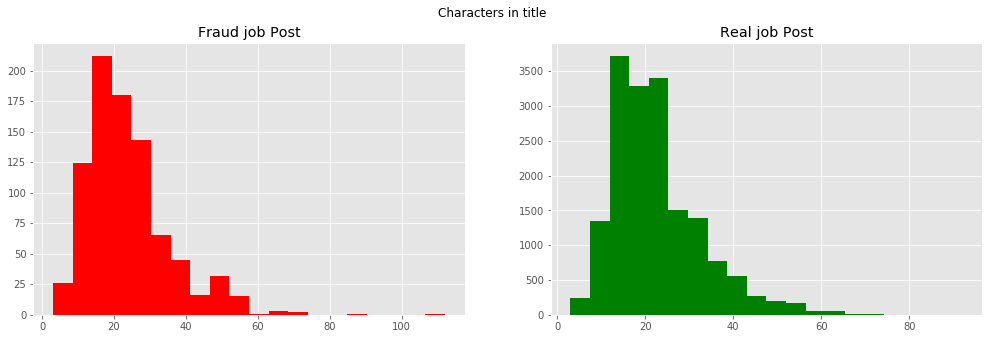

<Figure size 432x288 with 0 Axes>

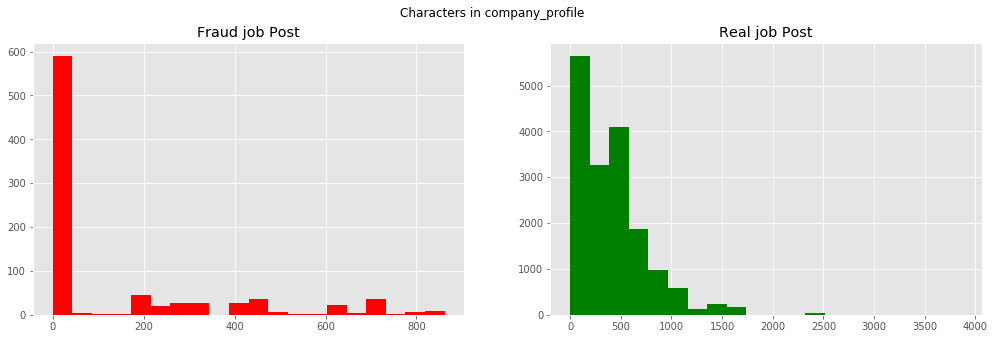

<Figure size 432x288 with 0 Axes>

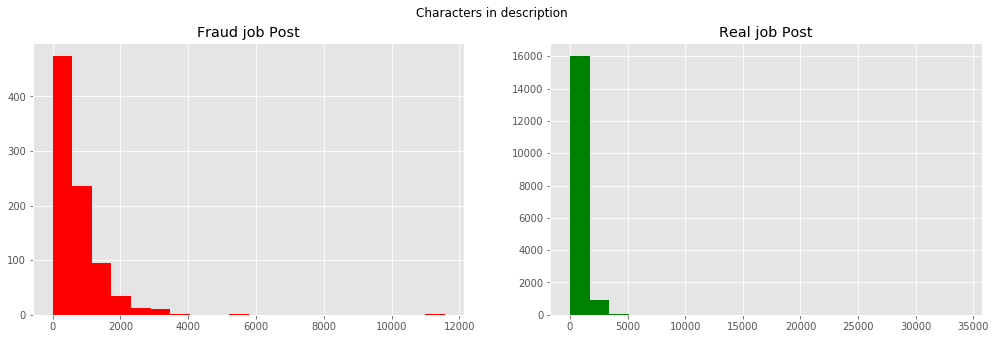

<Figure size 432x288 with 0 Axes>

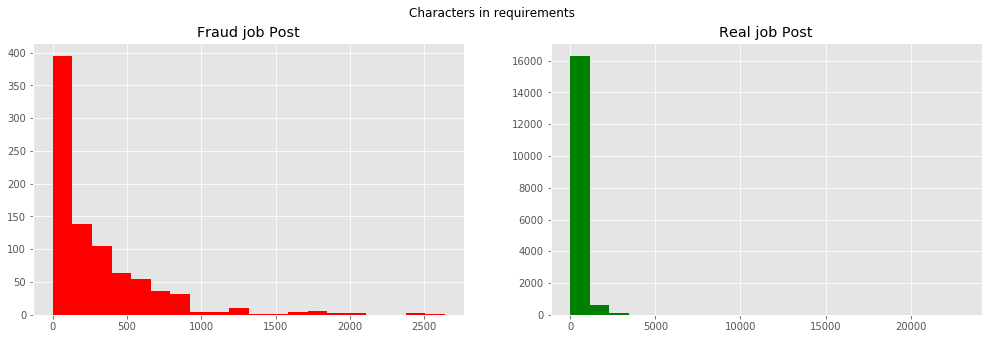

<Figure size 432x288 with 0 Axes>

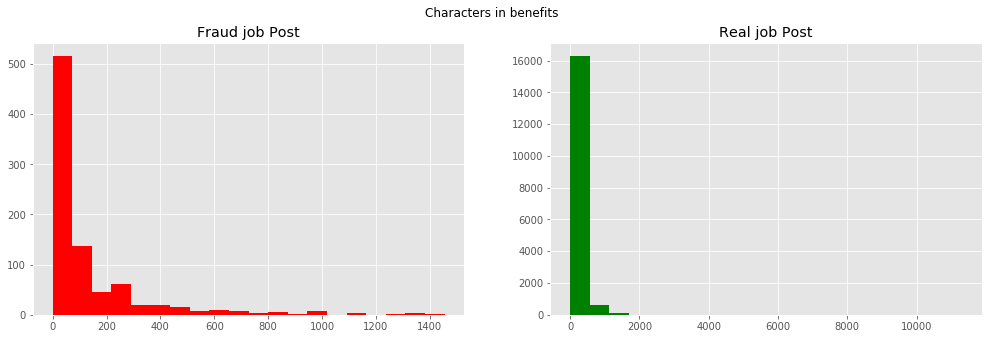

In [15]:
for col in text_cols:
    plot_text(data, col)

<Figure size 432x288 with 0 Axes>

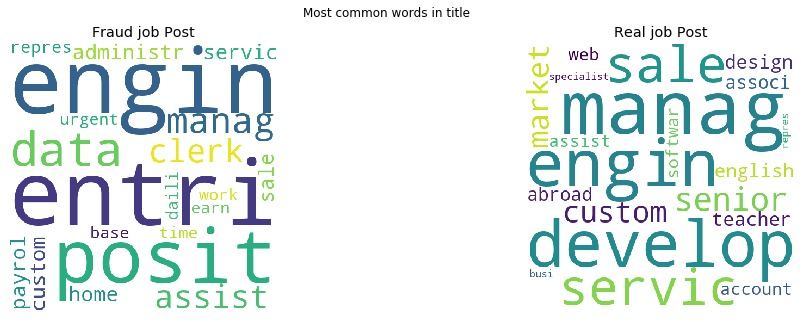

<Figure size 432x288 with 0 Axes>

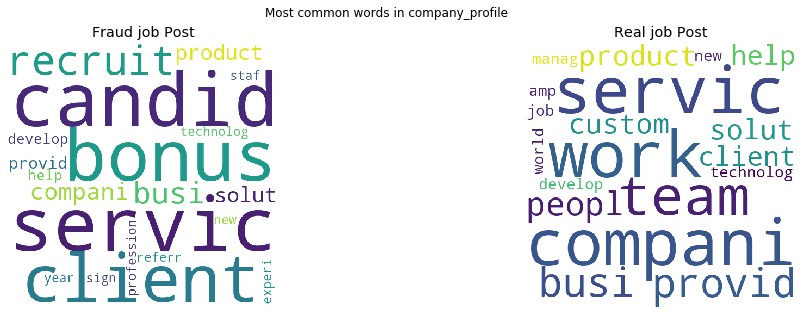

<Figure size 432x288 with 0 Axes>

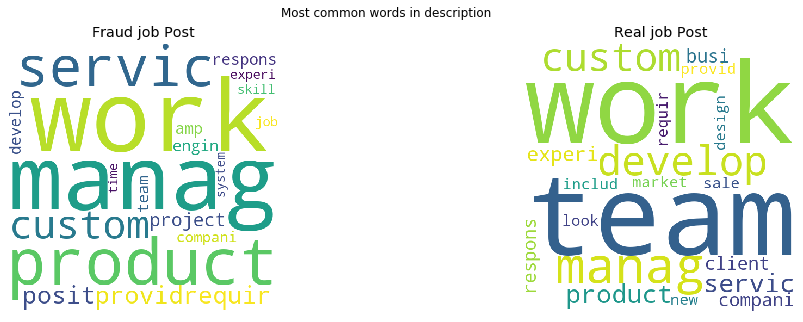

<Figure size 432x288 with 0 Axes>

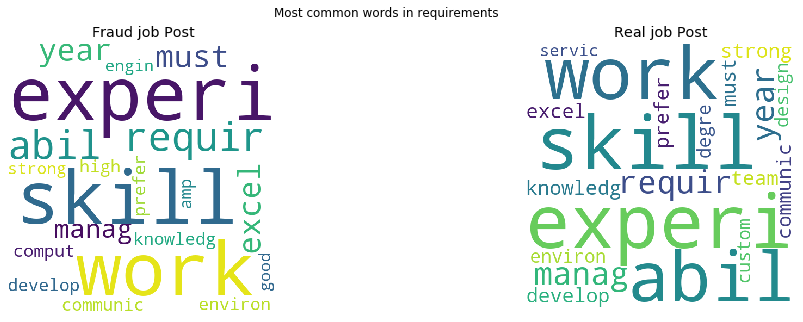

<Figure size 432x288 with 0 Axes>

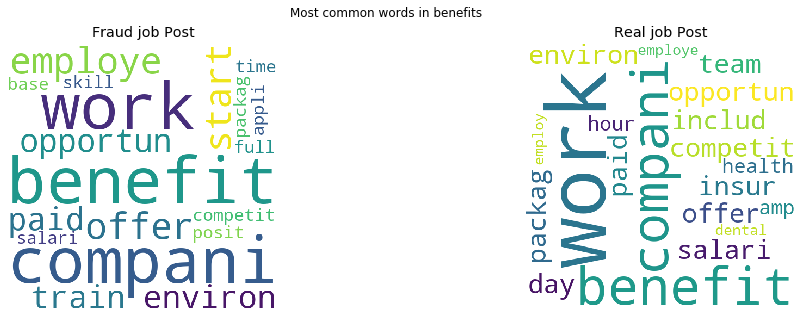

In [16]:
for col in text_cols:
    plot_wordcloud(data, col)

In [17]:
data["text"] = data["title"] + data["company_profile"] + data["description"] + data["requirements"] + data["benefits"]

In [18]:
data.to_pickle("data_text")

## Features Cleaning

In [19]:
df = data.copy()

In [20]:
clean_features(df)


## BASELINE MODEL

In [21]:
# Accuracy is useless in problems with unequal classes and has absolutely no predictive power

In [22]:
df["fraudulent"].value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

In [23]:
y_actual = np.array(df["fraudulent"])

In [24]:
y_pred0 = np.zeros(len(y_actual))
y_pred1 = np.ones(len(y_actual))
pred_y = np.random.choice([0,1],size=(len(y_actual),), p=[0.95,0.05])

In [25]:
cf = confusion_matrix(y_pred0, y_actual)


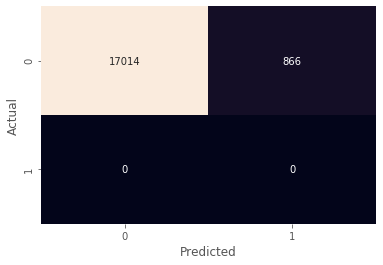

In [26]:
import seaborn as sns
fig = plt.figure()
ax = sns.heatmap(cf, annot=True, cbar=False, fmt='g')
ax.set(xlabel='Predicted', ylabel='Actual')
fig.savefig("images/conf_matrix", bbox_inches='tight')
plt.show()

### Baseline Results

In [27]:
#no frauds
generate_model_report(y_actual, y_pred0)

Accuracy: 0.952
Precision: 0.000
Recall: 0.000
F1 score: 0.000


/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
#all frauds
generate_model_report(y_actual, y_pred1)

Accuracy: 0.048
Precision: 0.048
Recall: 1.000
F1 score: 0.092


In [29]:
# random prediction
generate_model_report(y_actual,pred_y)

Accuracy: 0.904
Precision: 0.053
Recall: 0.059
F1 score: 0.056


In [30]:
# All categories value except 'department', 'function'

fit_df = df[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'text', 'fraudulent']]


In [31]:
cat_df = fit_df[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'fraudulent']]

fit_df_dummy = pd.get_dummies(cat_df)



In [32]:
text_cat_df = pd.concat([fit_df_dummy, fit_df["text"]], axis = 1)


In [33]:
text_cat_df.to_pickle("cleaned_textCol.pkl")

## To balance or not to balance

0    17014
1      866
Name: fraudulent, dtype: int64


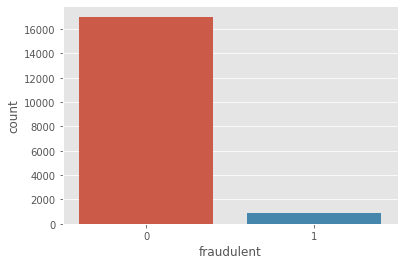

In [34]:
## Split first to avoid leakage and to handle imbalance


X = text_cat_df.drop("fraudulent", axis=1)
y = text_cat_df["fraudulent"]

X_cat, y_cat = fit_df_dummy.drop("fraudulent", axis=1), fit_df_dummy["fraudulent"]

# splitting text and categorical columns
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , test_size = .20, random_state=1)

#splitting only categorical columns
X_cat_train, X_cat_test, y_cat_train,y_cat_test = train_test_split(X_cat, y_cat, stratify=y , test_size = .20, random_state=1)


ax = sns.countplot(x = y, data = X)
print(y.value_counts())

# before balancing the data


## SMOTE

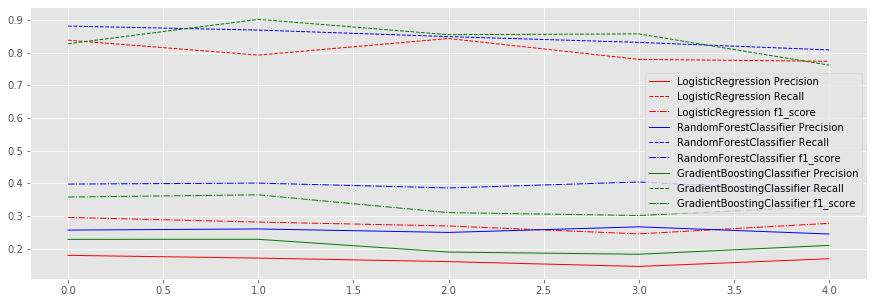

In [35]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators, X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='undersampling' )
ax.legend()

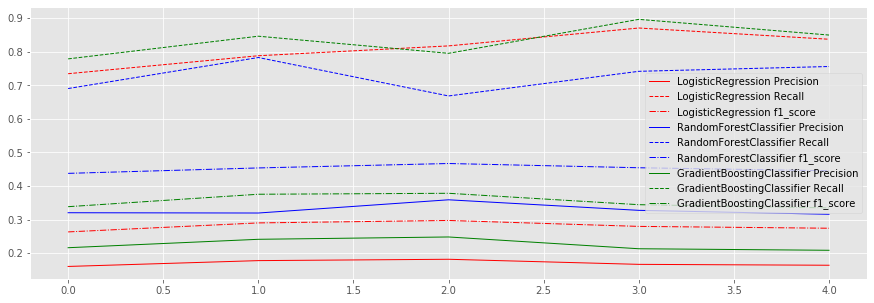

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='oversampling' )
ax.legend()

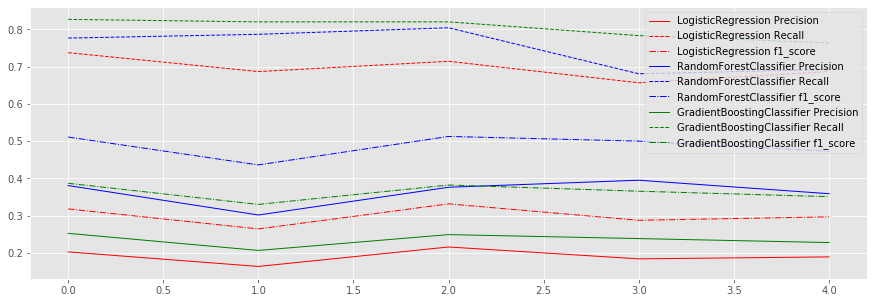

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='smote' )
ax.legend()

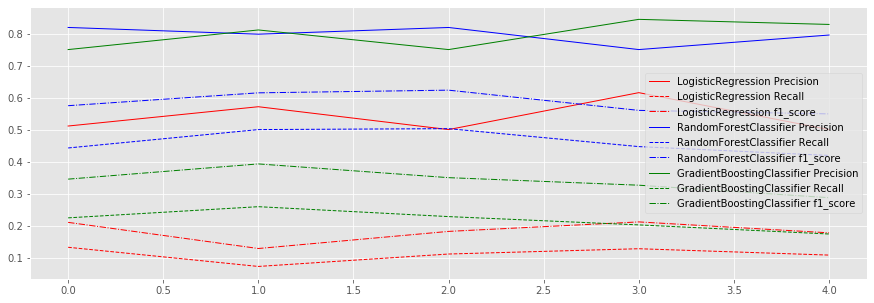

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))
estimators = [LogisticRegression(max_iter=500), RandomForestClassifier(), GradientBoostingClassifier()]
sampling_methods=["None", "undersampling", "oversampling", "smote"]
run_model(estimators,  X_cat.values, y_cat, names=[m.__class__.__name__ for m in estimators], ax=ax, sampling_method='None' )
ax.legend()

## Model only with categorical features

RandomForestClassifier F1 Score:  0.605
RandomForestClassifier PR AUC: 0.684
Accuracy: 0.969
Precision: 0.787
Recall: 0.491
F1 score: 0.605


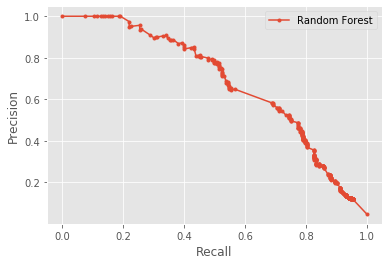

In [39]:
model = RandomForestClassifier()
model.fit(X_cat_train, y_cat_train)

yhat = model.predict_proba(X_cat_test)
pos_probs = yhat[:, 1]


y_pred = model.predict(X_cat_test)


# calculate the precision-recall auc
precision, recall, thresholds = precision_recall_curve(y_cat_test, pos_probs)
F1_Score = f1_score(y_cat_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Random Forest')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)

generate_model_report(y_cat_test, y_pred)
cm = confusion_matrix(y_cat_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

<Figure size 432x288 with 0 Axes>

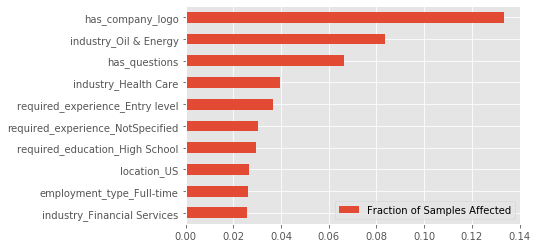

In [40]:
# Plot the feature importance
fig = plt.figure()
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=X_cat_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False)
y = feat_scores[:10]
y[::-1].plot(kind='barh')
fig.savefig(f"images/cat_feature_imp", bbox_inches='tight');

## TFIDF vectorization

In [41]:
tfidf = TfidfVectorizer(max_features = 2000)

In [83]:
import pickle
pickle.dump(tfidf, open("tfidf.pkl", "wb"))

In [42]:
tfidf_matrix_train = tfidf.fit_transform(X_train.text.values.astype('U'))

In [43]:
tfidf_matrix_test =  tfidf.transform(X_test.text.values.astype('U'))

In [44]:
nlp_train = pd.DataFrame(tfidf_matrix_train.toarray(), columns=tfidf.get_feature_names())
nlp_test = pd.DataFrame(tfidf_matrix_test.toarray(), columns=tfidf.get_feature_names())

In [45]:
nlp_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
cat_nlp_train = pd.concat([nlp_train, X_train], axis=1)

nlp_test.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
cat_nlp_test = pd.concat([nlp_test, X_test], axis=1)

In [46]:
cat_nlp_train = cat_nlp_train.drop("text", axis=1)
cat_nlp_test = cat_nlp_test.drop("text", axis=1);

No Skill F1 Score: 0.017
No Skill PR AUC: 0.077
Accuracy: 0.904
Precision: 0.017
Recall: 0.017
F1 score: 0.017


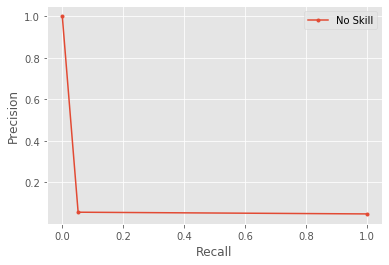

In [47]:
from sklearn.datasets import make_classification
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from matplotlib import pyplot


# setting up a dummy model
model = DummyClassifier(strategy='stratified')  #Predict 0 or 1 proportional to the prior probability in the dataset 
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
y_pred = model.predict(cat_nlp_test)
pos_probs = yhat[:, 1]



# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='No Skill')
print('No Skill F1 Score: %.3f' % F1_Score)
print('No Skill PR AUC: %.3f' % auc_score)

generate_model_report(y_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Best Threshold=0.300000, F-Score=0.828
Best Threshold=0.300000, Precision=0.904, Recall=0.763




RandomForestClassifier F1 Score:  0.746
RandomForestClassifier PR AUC: 0.900
Accuracy: 0.980
Precision: 1.000
Recall: 0.595
F1 score: 0.746


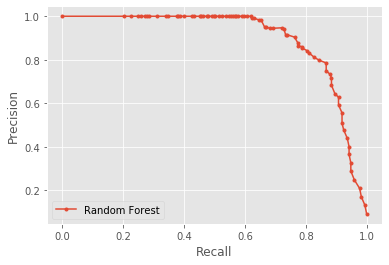

In [48]:
model = RandomForestClassifier()
model.fit(cat_nlp_train, y_train)

yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]


y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, thresholds = precision_recall_curve(y_test, pos_probs)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
print('Best Threshold=%f, Precision=%.3f, Recall=%.3f'  % (thresholds[ix], precision[ix], recall[ix]))
print("\n\n\n")
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Random Forest')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)

generate_model_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Index(['10', '100', '1000', '12', '13', '15', '1500', '1618', '18', '20',
       ...
       'required_experience_NotSpecified',
       'required_education_Associate Degree',
       'required_education_Bachelor's Degree',
       'required_education_Certification', 'required_education_Doctorate',
       'required_education_High School', 'required_education_Master's Degree',
       'required_education_Professional', 'required_education_Unspecified',
       'required_education_Vocational'],
      dtype='object', length=2059)

In [50]:
import pickle
pickle.dump(model, open("model.pkl", "wb"))

## Plot the feature importance


fig = plt.figure()
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=cat_nlp_train.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected', ascending = False)[:10]
y = feat_scores[:10]
y[::-1].plot(kind="barh")
fig.savefig(f"images/text_feature_imp", bbox_inches='tight');

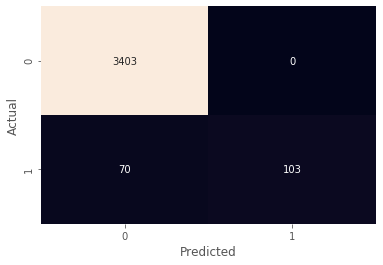

In [51]:
import seaborn as sns
fig = plt.figure()
ax = sns.heatmap(cm , annot=True, cbar=False, fmt='g')
ax.set(xlabel='Predicted', ylabel='Actual')
fig.savefig("images/conf_matrix", bbox_inches='tight')
plt.show()

GradientBoostingClassifier F1 Score:  0.664
GradientBoostingClassifier PR AUC: 0.742
Accuracy: 0.974
Precision: 0.869
Recall: 0.538
F1 score: 0.664


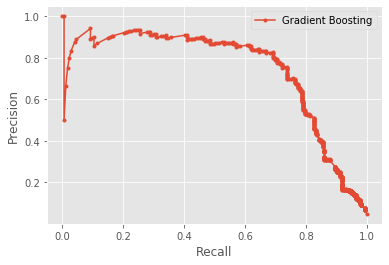

In [52]:
model = GradientBoostingClassifier()
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]
y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Gradient Boosting')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)
generate_model_report(y_test, y_pred)



# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

LogisticRegression F1 Score:  0.664
LogisticRegression PR AUC: 0.789
Accuracy: 0.974
Precision: 0.901
Recall: 0.526
F1 score: 0.664


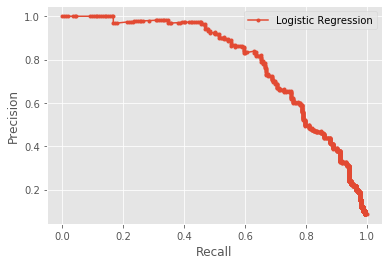

In [53]:
model = LogisticRegression(max_iter=500)
model.fit(cat_nlp_train, y_train)
yhat = model.predict_proba(cat_nlp_test)
pos_probs = yhat[:, 1]
y_pred = model.predict(cat_nlp_test)


# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
F1_Score = f1_score(y_test, y_pred)
auc_score = auc(recall, precision)
pyplot.plot(recall, precision, marker='.', label='Logistic Regression')

print(f'{model.__class__.__name__ } F1 Score:  %.3f' % F1_Score)
print(f'{model.__class__.__name__ } PR AUC: %.3f' % auc_score)
generate_model_report(y_test, y_pred)


# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# LSTM

In [54]:
lstm_df = pd.read_pickle("cleaned_textCol.pkl")

In [55]:
lstm_df = lstm_df[["text", "fraudulent"]]

In [56]:
lstm_df.fraudulent = lstm_df.fraudulent.replace([0,1],["Not fraud","fraud"])

In [57]:
from nltk.corpus import stopwords
lstm_df = lstm_df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
lstm_df.text = lstm_df.text.apply(clean_text)
lstm_df.text = lstm_df.text.str.replace('\d+', '')

In [58]:
X = lstm_df.text
y = lstm_df.fraudulent

In [59]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [60]:
y = le.fit_transform(y)
y.reshape(-1,1)

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.20)

In [62]:
import tensorflow as tf
keras = tf.keras

# The maximum number of words to be used. (most frequent)
max_words = 60000
# Max number of words in each complaint.
max_length = 250
# This is fixed.
embedding_dim = 100


tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 59332 unique tokens.


In [63]:
sequences = tokenizer.texts_to_sequences(X_train)
sequences_matrix = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length)
print('Shape of data tensor:', sequences_matrix.shape)

Shape of data tensor: (14304, 250)


In [73]:
from keras.layers import Embedding, LSTM, Dense, Input, Activation, Dropout
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

In [74]:
model = Sequential()
model.add(Embedding(max_words,150,input_length=max_length))
model.add(LSTM(64))

model.add(Dense(32, name="FC1"))
model.add(Activation("relu"))
# model.add(Dropout(0.4))

model.add(Dense(16, activation=tf.nn.relu))
model.add(Dropout(0.4))

model.add(Dense(1,name="out_layer"))
model.add(Activation("sigmoid"))

In [75]:
import keras.backend as K

def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1_score(y_true, y_pred):
    precision_ = precision(y_true, y_pred)
    recall_ = recall(y_true, y_pred)
    return 2*((precision_*recall_)/(precision_+recall_+K.epsilon()))

In [76]:
# model = RNN()
model.summary()
model.compile(loss="binary_crossentropy", optimizer=RMSprop(), metrics=["accuracy", precision, recall, f1_score])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 150)          9000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                55040     
_________________________________________________________________
FC1 (Dense)                  (None, 32)                2080      
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

In [77]:
model.fit(sequences_matrix, Y_train, batch_size=150, epochs=5, validation_split=.20, 
          callbacks=[EarlyStopping(monitor="val_loss", min_delta=0.0001)])

Epoch 1/5
77/77 [==============================] - 52s 677ms/step - loss: 0.2156 - accuracy: 0.9500 - precision: 0.3934 - recall: 0.1292 - f1_score: 0.1806 - val_loss: 0.1182 - val_accuracy: 0.9682 - val_precision: 0.7500 - val_recall: 0.3082 - val_f1_score: 0.4280
Epoch 2/5
77/77 [==============================] - 55s 709ms/step - loss: 0.1049 - accuracy: 0.9726 - precision: 0.8858 - recall: 0.5086 - f1_score: 0.6196 - val_loss: 0.1109 - val_accuracy: 0.9678 - val_precision: 0.6690 - val_recall: 0.5287 - val_f1_score: 0.5748
Epoch 3/5
77/77 [==============================] - 55s 718ms/step - loss: 0.0689 - accuracy: 0.9822 - precision: 0.9037 - recall: 0.7199 - f1_score: 0.7840 - val_loss: 0.1219 - val_accuracy: 0.9731 - val_precision: 0.7733 - val_recall: 0.4430 - val_f1_score: 0.5517


In [78]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequence_matrix = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length)

In [79]:
accr = model.evaluate(test_sequence_matrix, Y_test)

112/112 [==============================] - 5s 42ms/step - loss: 0.0951 - accuracy: 0.9796 - precision: 0.5179 - recall: 0.4268 - f1_score: 0.4528


In [80]:
print(f"Test set\n Loss:{accr[0]}\n Accuracy: {accr[1]}\n Precision: {accr[2]}\n Recall: {accr[3]}\n F1 Score: {accr[4]}")

Test set
 Loss:0.0951220691204071
 Accuracy: 0.979586124420166
 Precision: 0.5178571343421936
 Recall: 0.4267857074737549
 F1 Score: 0.4527849555015564


In [81]:
test_case = ["software team team company experience work health software development"]
# test_case = ["data entry at home bonus entri data entri"]
txts=tokenizer.texts_to_sequences(test_case)
txts = tf.keras.preprocessing.sequence.pad_sequences(txts,maxlen=max_length)

In [82]:
pred = model.predict(txts)
print(pred)

[[0.07801962]]


## Psycopg2

In [307]:
import psycopg2
conn = psycopg2.connect(dbname='postgres', user='postgres', host='localhost', port='5432', password='password')

In [308]:
cur = conn.cursor()

In [309]:
conn.autocommit = True

In [310]:
cur.close() # This is optional
conn.close() # Closing the connection also closes all cursors

In [311]:
conn = psycopg2.connect(dbname='jobs_fraud', user='postgres', host='localhost', port='5432', password='password')

In [312]:
cur = conn.cursor()

In [313]:
import os
path = os.getcwd()

In [314]:
path

'/Users/shwetasharma1/Desktop/Galvanize/capstone_3'

In [315]:
query = '''
        select *
    from jobs
    order by random()
    limit 11;

        '''
cur.execute(query)

In [317]:
table = cur.fetchall()

In [318]:
data = pd.DataFrame(table,columns=['title', 'location', 'department', 'salary_range', 'company_profile',
       'description', 'requirements', 'benefits', 'telecommuting',
       'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'in_balanced_dataset']) 

In [319]:
data

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
0,Customer Success Manager,"US, NY,",None,None,None,<p><b>Company Description:</b></p>\r\n<p>Sense...,"<ul>\r\n<li>A degree as a Registered Nurse, Re...",None,f,f,f,Full-time,Entry level,None,"Health, Wellness and Fitness",None,f,t
1,LPN-PRN contract,"US, OH, Celina",None,None,<p>MRSI is a nonprofit organization establishe...,"<p>We are seeking persons with passion, energy...",<p><b>MINIMUM QUALIFICATIONS:</b><br><b>Educat...,None,f,t,f,Contract,None,Associate Degree,Hospital & Health Care,Health Care Provider,f,f
2,Entry Level Full Time Business Analyst / BA Po...,"US, NJ, Princeton",None,60000-90000,<p><b>Precision Technologies (PTC)</b> is a le...,<p>Precision Technologies (PTC) is a leading <...,<p><b><b>Qualification</b>: </b>B.S./M.S. in C...,<p>The benefits include but not limited to:</p...,f,t,t,Full-time,Entry level,None,Information Technology and Services,Accounting/Auditing,f,f
3,Data Entry Clerk,US,HR Manager,20-3075,None,<p>CPI Data Services has partnered with a grow...,None,<p>Wage rate per hours</p>,f,f,f,Part-time,Not Applicable,Unspecified,Accounting,Administrative,t,t
4,Project Manager: Mechanical,"US, CA, Bakersfield",Oil & Energy,None,"<p><img src=""#URL_c28d7531510e8eaf53b48ae35739...",<p>Essential Duties and Responsibilities:</p>\...,<p>General Qualifications:</p>\r\n<ul>\r\n<li>...,"<p>What is Offered:</p>\r\n<p>* Clean, safe, e...",f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Oil & Energy,Project Management,t,f
5,Producer Internship,"GB, LND, London",Producer Team,None,<p>MediaMonks is the biggest creative digital ...,<p>MediaMonks London is in search of an inspir...,None,None,f,t,f,Full-time,Internship,None,Marketing and Advertising,None,f,f
6,Data Entry / Typist Work At Home,"US, TX, Houston",None,12-25,None,<p></p>\r\n<p>2-Workonline is seeking individu...,<p>Must be able to work from home</p>,<p>Telecommuting from home</p>,f,t,f,Full-time,Entry level,High School or equivalent,Consumer Services,Customer Service,t,t
7,Web/graphic Designer,"GR, I, Marousi",None,None,"<p><b>We are a group </b>of enthusiastic, conn...",<p>The Flying Pot is looking for a communicati...,<ul>\r\n<li>Experience with Adobe Creative Sui...,"<p><b>We are a group </b>of enthusiastic, conn...",f,t,t,Full-time,Entry level,Unspecified,Graphic Design,Art/Creative,f,f
8,Customer Services Associate - Document Scanning,"US, CT, Windsor",None,None,"<p>Novitex Enterprise Solutions, formerly Pitn...",<p>We are currently seeking a Customer Service...,<p><b>Required Qualifications:</b></p>\r\n<ul>...,None,f,t,f,Full-time,Entry level,High School or equivalent,Hospital & Health Care,Customer Service,f,f


## Make predictions

In [275]:
data_sample = pd.read_csv("emscad_v1.csv")
data_sample = data_sample.sample(10)
data_testing = data_sample.copy()

In [276]:
data_testing.drop("fraudulent", axis= 1, inplace=True)
data_testing.drop('in_balanced_dataset', axis= 1, inplace=True)

In [277]:
binary_cols = ["telecommuting", "has_company_logo","has_questions"]

for col in binary_cols:
    binarize(data_testing,col)

fill_nulls(data_testing)

In [278]:
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]

for col in text_cols:
    clean_cols(data_testing,col)

In [279]:
data_testing["text"] = data_testing["title"] + data_testing["company_profile"] + data_testing["description"] + data_testing["requirements"] + data_testing["benefits"]

clean_features(data_testing)

In [280]:
len(data_testing.columns)

17

In [281]:
rf_test = data_testing[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'text']]
rf_cat_df = rf_test[['location', 'industry', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education']]
rf_fit_df_dummy = pd.get_dummies(rf_cat_df)

In [283]:
rf_text_cat = pd.concat([rf_fit_df_dummy, rf_test["text"]], axis = 1)

In [284]:
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('tfidf.pkl', 'rb') as f:
    tfidf = pickle.load(f)

In [285]:
tfidf_matrix =  tfidf.transform(rf_text_cat.text.values.astype('U'))

data_nlp = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())

In [286]:
data_nlp.reset_index(drop=True, inplace=True)
rf_text_cat.reset_index(drop=True, inplace=True)
df_nlp_cat = pd.concat([rf_text_cat, data_nlp], axis=1)
df_nlp_cat = df_nlp_cat.drop("text", axis=1)

In [287]:
len(df_nlp_cat.columns)

2018

In [288]:
len(cat_nlp_train.columns)

2059

In [289]:
df_nlp_cat = df_nlp_cat.fillna(0)

In [290]:
 # Get missing columns in the training test
missing_cols = set(cat_nlp_test.columns) - set(df_nlp_cat.columns)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    df_nlp_cat[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
df_nlp_cat = df_nlp_cat[cat_nlp_test.columns]

In [291]:

y_preds = model.predict_proba(df_nlp_cat)[:,1]

y_preds_test = np.array(["Fraud" if val >=0.25 else "Not fraud" for val in y_preds])

y_preds_df = pd.DataFrame(y_preds_test)



In [292]:
y_preds_df

,0
0,Not fraud
1,Not fraud
2,Not fraud
3,Not fraud
4,Not fraud
5,Not fraud
6,Not fraud
7,Not fraud
8,Not fraud
9,Not fraud


In [294]:
data_sample

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset
8238,Software Engineering Intern,"US, IA, Dubuque",Product Development,NaN,"<p>We design, build, sell, and service the mos...","<p>WANTED: A fearless, scrappy intern with a ...",<p><b>Who you are…</b></p>\r\n<ul>\r\n<li>You’...,NaN,f,t,t,Part-time,Internship,NaN,Computer Software,NaN,f,f
4435,Technical Project Manager,"GB, LND, London",NaN,45000-55000,"<p>Formed in 2006, <b>Saul&amp;Partners </b>is...",<p><b>The Client:</b></p>\r\n<p>Our client is ...,"<p>As part of a strategic growth, our client, ...",<p>£45k basic salary + £25k commission</p>\r\n...,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Online Media,Project Management,f,f
7382,Call Center Supervisor,"US, VA, Virginia Beach",NaN,NaN,<p>Tidewater Finance Co. was established in 19...,"<p>Tidewater Finance Company, located in Virgi...",<p>Qualified candidates should possess the fol...,<p>Our company offers a <b>competitive salary ...,f,t,f,Full-time,Mid-Senior level,Unspecified,Financial Services,Management,f,f
15330,English Teacher Abroad,"US, WA, Ellensburg",NaN,NaN,<p>We help teachers get safe &amp; secure jobs...,"<p>Play with kids, get paid for it </p>\r\n<p>...",<p>University degree required. TEFL / TESOL / ...,<p>See job description</p>,f,t,t,Contract,NaN,Bachelor's Degree,Education Management,NaN,f,f
5528,Web Developer,"US, WA, Bellevue",NaN,NaN,"<p>People, Process and Tools come together at ...",<h3>Summary</h3>\r\n<p>This position involves ...,<h3>Personal Skills</h3>\r\n<ul>\r\n<li>4+ yea...,NaN,f,t,t,NaN,NaN,NaN,NaN,NaN,f,f
2715,Office Manager,"US, NY, New York",NaN,NaN,<p>We’ve built revolutionary technology that i...,"<p>As <b>Office Manager</b>, you will keep Via...",NaN,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f
11831,Product Designer,"FR, J, Paris",NaN,NaN,<p>Mention changes the way you monitor the web...,<p>We are looking for an extra-ordinary talent...,<ul>\r\n<li>3+ years of experience working in ...,<ul>\r\n<li>Working in a fast growing startup ...,f,t,t,Full-time,NaN,NaN,Internet,Design,f,f
8316,iOS Developer,"US, IL, Chicago",Engineering,NaN,<p>Rithmio is an Illinois-headquartered startu...,<p>Rithmio’s software engineers develop the ne...,NaN,NaN,f,t,f,NaN,NaN,NaN,NaN,Engineering,f,f
2618,Hotel Housekeeper,"US, VA, Harrisonburg",Hampton Inn University Area,NaN,"<p>Quality accommodations, exceptional service...",<p><b>SUMMARY:</b></p>\r\n<p>The Housekeeper i...,<ul>\r\n<li>Experience in some cleaning capaci...,"<ul>\r\n<li>Competative Pay,</li>\r\n<li>Vacat...",f,t,t,NaN,NaN,NaN,NaN,NaN,f,f
13444,"Director, Business Development & Strategy","US, NY, New York City",Finance,70-150,NaN,<p>Experience: 5-15 years<br>Location: New Yor...,<p> Bilingual English and Spanish and/or Portu...,NaN,f,f,t,Full-time,Director,Bachelor's Degree,Capital Markets,Finance,f,f


In [295]:
data_sample.reset_index(drop=True, inplace=True)
y_preds_df.reset_index(drop=True, inplace=True)

final_table = pd.concat([data_sample, y_preds_df], axis = 1)

In [296]:
final_table

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,in_balanced_dataset,0
0,Software Engineering Intern,"US, IA, Dubuque",Product Development,NaN,"<p>We design, build, sell, and service the mos...","<p>WANTED: A fearless, scrappy intern with a ...",<p><b>Who you are…</b></p>\r\n<ul>\r\n<li>You’...,NaN,f,t,t,Part-time,Internship,NaN,Computer Software,NaN,f,f,Not fraud
1,Technical Project Manager,"GB, LND, London",NaN,45000-55000,"<p>Formed in 2006, <b>Saul&amp;Partners </b>is...",<p><b>The Client:</b></p>\r\n<p>Our client is ...,"<p>As part of a strategic growth, our client, ...",<p>£45k basic salary + £25k commission</p>\r\n...,f,t,t,Full-time,Mid-Senior level,Bachelor's Degree,Online Media,Project Management,f,f,Not fraud
2,Call Center Supervisor,"US, VA, Virginia Beach",NaN,NaN,<p>Tidewater Finance Co. was established in 19...,"<p>Tidewater Finance Company, located in Virgi...",<p>Qualified candidates should possess the fol...,<p>Our company offers a <b>competitive salary ...,f,t,f,Full-time,Mid-Senior level,Unspecified,Financial Services,Management,f,f,Not fraud
3,English Teacher Abroad,"US, WA, Ellensburg",NaN,NaN,<p>We help teachers get safe &amp; secure jobs...,"<p>Play with kids, get paid for it </p>\r\n<p>...",<p>University degree required. TEFL / TESOL / ...,<p>See job description</p>,f,t,t,Contract,NaN,Bachelor's Degree,Education Management,NaN,f,f,Not fraud
4,Web Developer,"US, WA, Bellevue",NaN,NaN,"<p>People, Process and Tools come together at ...",<h3>Summary</h3>\r\n<p>This position involves ...,<h3>Personal Skills</h3>\r\n<ul>\r\n<li>4+ yea...,NaN,f,t,t,NaN,NaN,NaN,NaN,NaN,f,f,Not fraud
5,Office Manager,"US, NY, New York",NaN,NaN,<p>We’ve built revolutionary technology that i...,"<p>As <b>Office Manager</b>, you will keep Via...",NaN,NaN,f,t,f,NaN,NaN,NaN,NaN,NaN,f,f,Not fraud
6,Product Designer,"FR, J, Paris",NaN,NaN,<p>Mention changes the way you monitor the web...,<p>We are looking for an extra-ordinary talent...,<ul>\r\n<li>3+ years of experience working in ...,<ul>\r\n<li>Working in a fast growing startup ...,f,t,t,Full-time,NaN,NaN,Internet,Design,f,f,Not fraud
7,iOS Developer,"US, IL, Chicago",Engineering,NaN,<p>Rithmio is an Illinois-headquartered startu...,<p>Rithmio’s software engineers develop the ne...,NaN,NaN,f,t,f,NaN,NaN,NaN,NaN,Engineering,f,f,Not fraud
8,Hotel Housekeeper,"US, VA, Harrisonburg",Hampton Inn University Area,NaN,"<p>Quality accommodations, exceptional service...",<p><b>SUMMARY:</b></p>\r\n<p>The Housekeeper i...,<ul>\r\n<li>Experience in some cleaning capaci...,"<ul>\r\n<li>Competative Pay,</li>\r\n<li>Vacat...",f,t,t,NaN,NaN,NaN,NaN,NaN,f,f,Not fraud
9,"Director, Business Development & Strategy","US, NY, New York City",Finance,70-150,NaN,<p>Experience: 5-15 years<br>Location: New Yor...,<p> Bilingual English and Spanish and/or Portu...,NaN,f,f,t,Full-time,Director,Bachelor's Degree,Capital Markets,Finance,f,f,Not fraud
